# Real vs Fake Tweet Feature Analysis

## Objective
Analyze the key differences between original real and fake tweets to understand:
1. Why traditional ML models (Random Forest + Count/TF-IDF) perform so well
2. What specific features distinguish real from fake tweets
3. How to generate better synthetic data based on these insights

## Dataset
- **Real tweets**: 68,985 samples
- **Fake tweets**: 65,213 samples
- **Source**: Twitter_Analysis.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from textstat import flesch_reading_ease, flesch_kincaid_grade

# Try to import TextBlob for sentiment analysis
try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False
    print("TextBlob not available, sentiment analysis will be skipped")

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Basic Overview

In [3]:
# Load the dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['majority_target'].value_counts())

# Separate real and fake tweets
real_tweets = df[df['majority_target'] == True]['tweet'].tolist()
fake_tweets = df[df['majority_target'] == False]['tweet'].tolist()

print(f"\nReal tweets: {len(real_tweets)}")
print(f"Fake tweets: {len(fake_tweets)}")
print(f"Total tweets: {len(real_tweets) + len(fake_tweets)}")

Dataset shape: (134198, 64)
Columns: ['Unnamed: 0', 'majority_target', 'statement', 'BinaryNumTarget', 'tweet', 'followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'listed_count', 'following', 'embeddings', 'BotScore', 'BotScoreBinary', 'cred', 'normalize_influence', 'mentions', 'quotes', 'replies', 'retweets', 'favourites', 'hashtags', 'URLs', 'unique_count', 'total_count', 'ORG_percentage', 'NORP_percentage', 'GPE_percentage', 'PERSON_percentage', 'MONEY_percentage', 'DATE_percentage', 'CARDINAL_percentage', 'PERCENT_percentage', 'ORDINAL_percentage', 'FAC_percentage', 'LAW_percentage', 'PRODUCT_percentage', 'EVENT_percentage', 'TIME_percentage', 'LOC_percentage', 'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LANGUAGE_percentage', 'Word count', 'Max word length', 'Min word length', 'Average word length', 'present_verbs', 'past_verbs', 'adjectives', 'adverbs', 'adpositions', 'pronouns', 'TOs', 'determiners', 'conjunctions', 'dots', 'exclamation', 'questions',

## 2. Comprehensive Feature Extraction

We'll extract multiple types of features to understand the differences between real and fake tweets:

In [4]:
class ComprehensiveFeatureExtractor:
    """Extract comprehensive features from tweets for analysis"""
    
    def __init__(self):
        # Predefined word lists for analysis
        self.positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love', 'like', 'happy', 'joy', 'awesome', 'perfect', 'best', 'brilliant', 'outstanding']
        self.negative_words = ['bad', 'terrible', 'awful', 'horrible', 'hate', 'dislike', 'sad', 'angry', 'frustrated', 'disappointed', 'worst', 'disgusting', 'pathetic', 'stupid', 'ridiculous']
        self.urgency_words = ['urgent', 'immediately', 'asap', 'quickly', 'fast', 'hurry', 'rush', 'emergency', 'breaking', 'alert', 'critical', 'important', 'now', 'instant']
        self.sensational_words = ['shocking', 'unbelievable', 'incredible', 'amazing', 'stunning', 'outrageous', 'scandalous', 'exclusive', 'secret', 'exposed', 'revealed', 'bombshell']
        self.certainty_words = ['definitely', 'absolutely', 'certainly', 'surely', 'obviously', 'clearly', 'undoubtedly', 'without doubt', 'guaranteed', 'proven', 'fact']
        
    def extract_length_features(self, texts):
        """Extract length-based features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            words = text_str.split()
            
            features.append({
                'char_count': len(text_str),
                'word_count': len(words),
                'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
                'sentence_count': len([s for s in text_str.split('.') if s.strip()]),
                'avg_sentence_length': len(words) / max(1, len([s for s in text_str.split('.') if s.strip()]))
            })
            
        return pd.DataFrame(features)
    
    def extract_stylistic_features(self, texts):
        """Extract stylistic and structural features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            
            features.append({
                'hashtag_count': text_str.count('#'),
                'mention_count': text_str.count('@'),
                'url_count': len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text_str)),
                'exclamation_count': text_str.count('!'),
                'question_count': text_str.count('?'),
                'ellipsis_count': text_str.count('...'),
                'caps_word_count': len([word for word in text_str.split() if word.isupper() and len(word) > 1]),
                'upper_ratio': sum(1 for c in text_str if c.isupper()) / max(1, len(text_str)),
                'punctuation_density': sum(1 for c in text_str if c in '.,!?;:') / max(1, len(text_str)),
                'digit_count': sum(1 for c in text_str if c.isdigit()),
                'digit_ratio': sum(1 for c in text_str if c.isdigit()) / max(1, len(text_str))
            })
            
        return pd.DataFrame(features)
    
    def extract_semantic_features(self, texts):
        """Extract semantic and sentiment features"""
        features = []
        
        for text in texts:
            text_str = str(text).lower()
            words = text_str.split()
            
            # Word category counts
            positive_count = sum(1 for word in words if word in self.positive_words)
            negative_count = sum(1 for word in words if word in self.negative_words)
            urgency_count = sum(1 for word in words if word in self.urgency_words)
            sensational_count = sum(1 for word in words if word in self.sensational_words)
            certainty_count = sum(1 for word in words if word in self.certainty_words)
            
            # Sentiment analysis if available
            polarity = 0
            subjectivity = 0
            if TEXTBLOB_AVAILABLE:
                try:
                    blob = TextBlob(text)
                    polarity = blob.sentiment.polarity
                    subjectivity = blob.sentiment.subjectivity
                except:
                    pass
            
            features.append({
                'positive_word_count': positive_count,
                'negative_word_count': negative_count,
                'urgency_word_count': urgency_count,
                'sensational_word_count': sensational_count,
                'certainty_word_count': certainty_count,
                'sentiment_polarity': polarity,
                'sentiment_subjectivity': subjectivity,
                'positive_negative_ratio': positive_count / max(1, negative_count),
                'emotional_intensity': (positive_count + negative_count) / max(1, len(words))
            })
            
        return pd.DataFrame(features)
    
    def extract_linguistic_features(self, texts):
        """Extract linguistic complexity features"""
        features = []
        
        for text in texts:
            text_str = str(text)
            
            # Readability scores
            try:
                flesch_score = flesch_reading_ease(text_str)
                fk_grade = flesch_kincaid_grade(text_str)
            except:
                flesch_score = 0
                fk_grade = 0
            
            # Lexical diversity
            words = text_str.lower().split()
            unique_words = len(set(words))
            lexical_diversity = unique_words / max(1, len(words))
            
            # Function words (pronouns, articles, prepositions)
            function_words = ['i', 'you', 'he', 'she', 'it', 'we', 'they', 'the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'with', 'by']
            function_word_count = sum(1 for word in words if word in function_words)
            function_word_ratio = function_word_count / max(1, len(words))
            
            features.append({
                'flesch_reading_ease': flesch_score,
                'flesch_kincaid_grade': fk_grade,
                'lexical_diversity': lexical_diversity,
                'function_word_ratio': function_word_ratio,
                'unique_word_count': unique_words,
                'repetition_ratio': 1 - lexical_diversity
            })
            
        return pd.DataFrame(features)
    
    def extract_all_features(self, texts, label):
        """Extract all feature types and combine them"""
        print(f"Extracting features for {len(texts)} {label} tweets...")
        
        length_features = self.extract_length_features(texts)
        stylistic_features = self.extract_stylistic_features(texts)
        semantic_features = self.extract_semantic_features(texts)
        linguistic_features = self.extract_linguistic_features(texts)
        
        # Combine all features
        all_features = pd.concat([
            length_features,
            stylistic_features,
            semantic_features,
            linguistic_features
        ], axis=1)
        
        all_features['label'] = label
        all_features['text'] = texts
        
        return all_features

# Initialize feature extractor
extractor = ComprehensiveFeatureExtractor()

## 3. Extract Features for Real and Fake Tweets

In [ ]:
# Extract features for both real and fake tweets
print("Starting feature extraction on FULL dataset...")

# Use full dataset for comprehensive analysis
print(f"Using all {len(real_tweets):,} real tweets")
print(f"Using all {len(fake_tweets):,} fake tweets")

real_sample = real_tweets
fake_sample = fake_tweets

# Extract features
real_features = extractor.extract_all_features(real_sample, 'real')
fake_features = extractor.extract_all_features(fake_sample, 'fake')

# Combine for analysis
combined_features = pd.concat([real_features, fake_features], ignore_index=True)

print(f"\nFeature extraction complete!")
print(f"Real tweets analyzed: {len(real_features)}")
print(f"Fake tweets analyzed: {len(fake_features)}")
print(f"Total features extracted: {combined_features.shape[1] - 2}")  # -2 for label and text columns

# Display feature columns
feature_columns = [col for col in combined_features.columns if col not in ['label', 'text']]
print(f"\nFeature categories extracted: {len(feature_columns)}")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

## 4. Statistical Analysis - Feature Differences

In [6]:
# Calculate statistical differences between real and fake tweets
def calculate_feature_differences(df, feature_columns):
    """Calculate statistical differences between real and fake tweets"""
    differences = []
    
    real_data = df[df['label'] == 'real']
    fake_data = df[df['label'] == 'fake']
    
    for feature in feature_columns:
        real_values = real_data[feature].dropna()
        fake_values = fake_data[feature].dropna()
        
        if len(real_values) > 0 and len(fake_values) > 0:
            # Basic statistics
            real_mean = real_values.mean()
            fake_mean = fake_values.mean()
            real_std = real_values.std()
            fake_std = fake_values.std()
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
            cohens_d = (fake_mean - real_mean) / pooled_std if pooled_std > 0 else 0
            
            # Statistical test
            try:
                t_stat, p_value = stats.ttest_ind(real_values, fake_values)
            except:
                t_stat, p_value = 0, 1
            
            differences.append({
                'feature': feature,
                'real_mean': real_mean,
                'fake_mean': fake_mean,
                'real_std': real_std,
                'fake_std': fake_std,
                'mean_difference': fake_mean - real_mean,
                'percent_difference': ((fake_mean - real_mean) / real_mean * 100) if real_mean != 0 else 0,
                'cohens_d': cohens_d,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.001  # Bonferroni correction for multiple tests
            })
    
    return pd.DataFrame(differences)

# Calculate differences
feature_differences = calculate_feature_differences(combined_features, feature_columns)

# Sort by effect size
feature_differences['abs_cohens_d'] = abs(feature_differences['cohens_d'])
feature_differences = feature_differences.sort_values('abs_cohens_d', ascending=False)

print("Top 15 Most Distinguishing Features (by Effect Size):")
print("=" * 80)

top_features = feature_differences.head(15)
for _, row in top_features.iterrows():
    direction = "↗️" if row['cohens_d'] > 0 else "↘️"
    significance = "***" if row['significant'] else "ns"
    
    print(f"{direction} {row['feature']:<25} | "
          f"Cohen's d: {row['cohens_d']:6.3f} | "
          f"Real: {row['real_mean']:8.3f} | "
          f"Fake: {row['fake_mean']:8.3f} | "
          f"Diff: {row['percent_difference']:6.1f}% | "
          f"{significance}")

Top 15 Most Distinguishing Features (by Effect Size):
↗️ word_count                | Cohen's d:  0.169 | Real:   34.069 | Fake:   36.322 | Diff:    6.6% | ***
↗️ unique_word_count         | Cohen's d:  0.158 | Real:   30.364 | Fake:   32.124 | Diff:    5.8% | ***
↗️ char_count                | Cohen's d:  0.133 | Real:  211.695 | Fake:  223.468 | Diff:    5.6% | ***
↗️ exclamation_count         | Cohen's d:  0.124 | Real:    0.198 | Fake:    0.309 | Diff:   56.0% | ***
↘️ digit_ratio               | Cohen's d: -0.115 | Real:    0.017 | Fake:    0.014 | Diff:  -16.6% | ***
↘️ hashtag_count             | Cohen's d: -0.112 | Real:    0.245 | Fake:    0.157 | Diff:  -35.7% | ***
↗️ flesch_reading_ease       | Cohen's d:  0.111 | Real:   53.054 | Fake:   55.669 | Diff:    4.9% | ***
↘️ lexical_diversity         | Cohen's d: -0.108 | Real:    0.906 | Fake:    0.898 | Diff:   -0.8% | ***
↗️ repetition_ratio          | Cohen's d:  0.108 | Real:    0.094 | Fake:    0.102 | Diff:    8.1% | ***
↗

## 5. Feature Distribution Visualizations

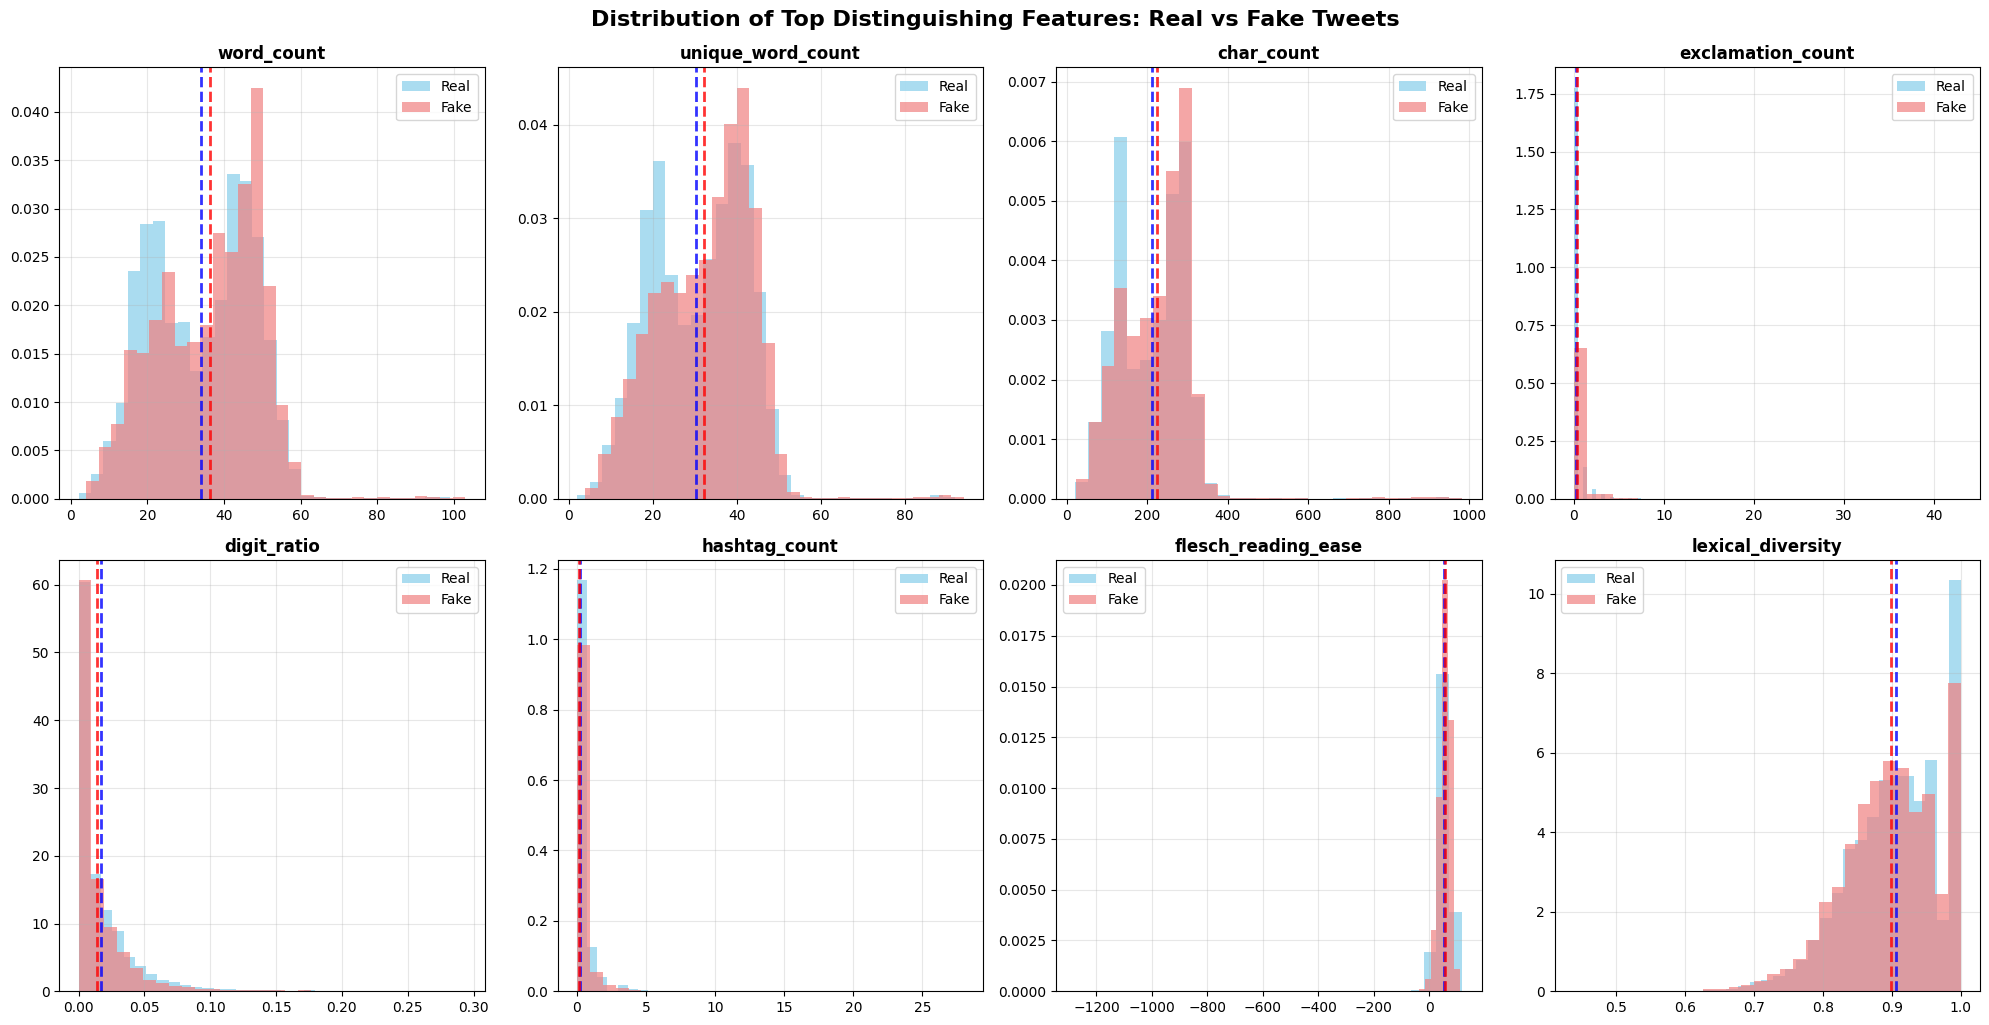

In [7]:
# Create comprehensive visualization of top distinguishing features
def plot_feature_distributions(df, top_features_df, n_features=8):
    """Plot distributions of top distinguishing features"""
    
    top_feature_names = top_features_df.head(n_features)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    real_data = df[df['label'] == 'real']
    fake_data = df[df['label'] == 'fake']
    
    for i, feature in enumerate(top_feature_names):
        ax = axes[i]
        
        # Plot distributions
        real_values = real_data[feature].dropna()
        fake_values = fake_data[feature].dropna()
        
        ax.hist(real_values, bins=30, alpha=0.7, label='Real', color='skyblue', density=True)
        ax.hist(fake_values, bins=30, alpha=0.7, label='Fake', color='lightcoral', density=True)
        
        # Add mean lines
        ax.axvline(real_values.mean(), color='blue', linestyle='--', alpha=0.8, linewidth=2)
        ax.axvline(fake_values.mean(), color='red', linestyle='--', alpha=0.8, linewidth=2)
        
        ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Distribution of Top Distinguishing Features: Real vs Fake Tweets', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

plot_feature_distributions(combined_features, feature_differences)

## 6. Feature Correlation Analysis

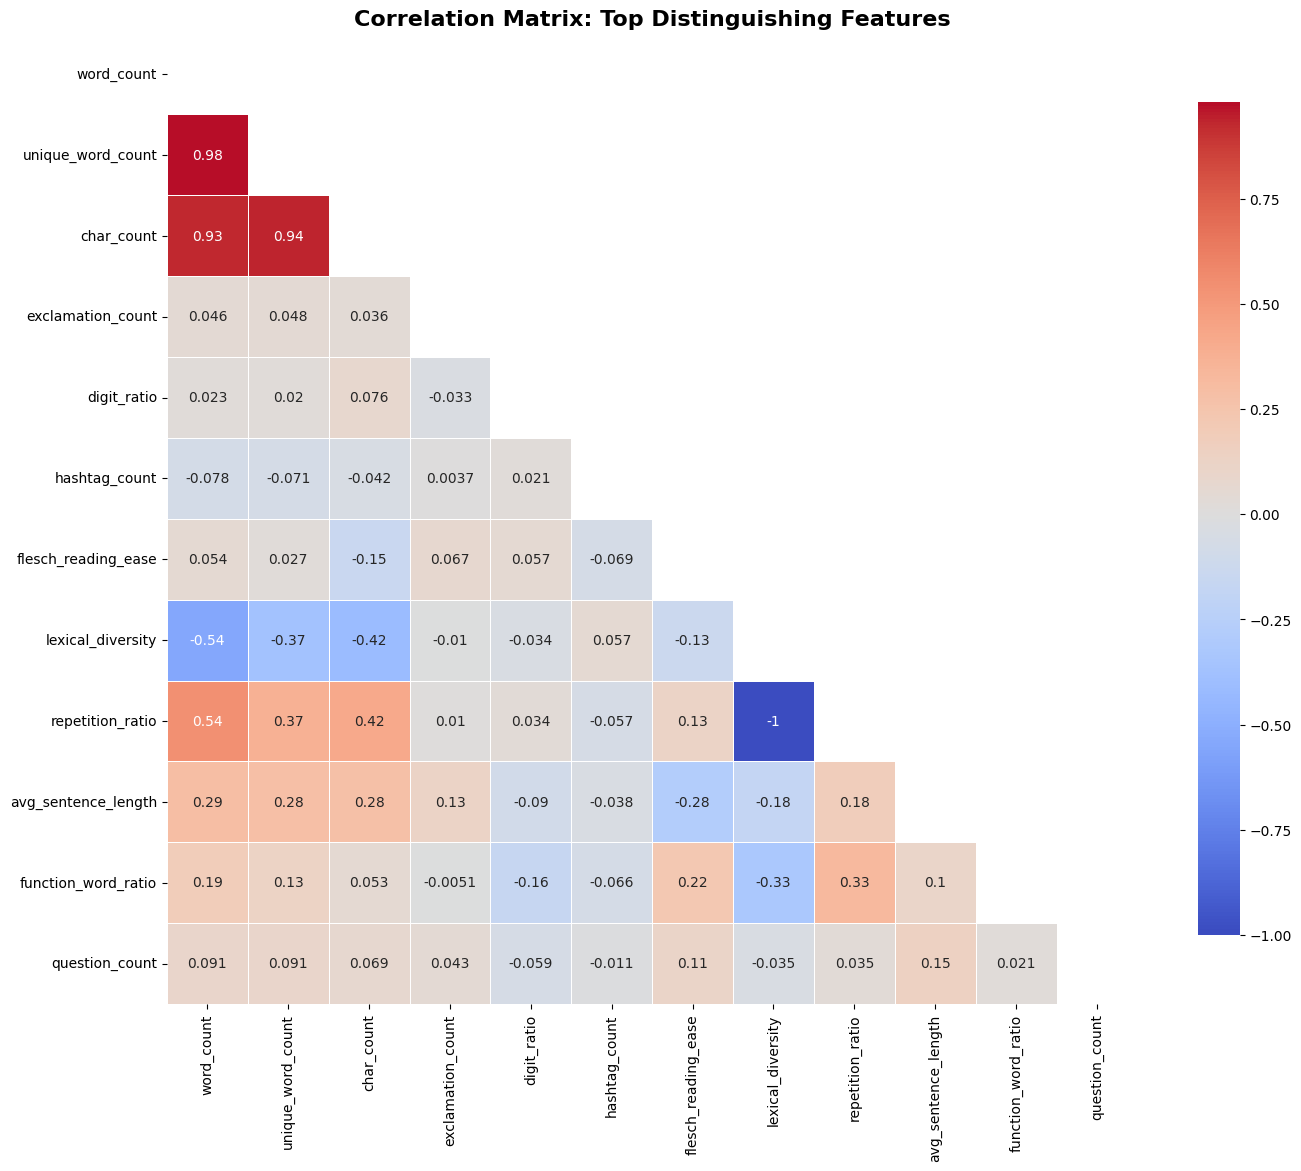

In [8]:
# Analyze correlations between features
numeric_features = combined_features[feature_columns].select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numeric_features.corr()

# Plot correlation heatmap for top features
top_feature_names = feature_differences.head(12)['feature'].tolist()
top_correlations = correlation_matrix.loc[top_feature_names, top_feature_names]

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(top_correlations, dtype=bool))
sns.heatmap(top_correlations, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Top Distinguishing Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Most Important N-grams Analysis

In [21]:
# Analyze most discriminative n-grams between real and fake tweets
def analyze_discriminative_ngrams(real_texts, fake_texts, n_grams=(1, 2), top_n=20):
    """Find most discriminative n-grams between real and fake tweets"""
    
    # Create vectorizers
    vectorizer = CountVectorizer(max_features=5000, stop_words='english', 
                                ngram_range=n_grams, min_df=5)
    
    # Fit on all texts
    all_texts = real_texts + fake_texts
    vectorizer.fit(all_texts)
    
    # Transform real and fake texts
    real_matrix = vectorizer.transform(real_texts)
    fake_matrix = vectorizer.transform(fake_texts)
    
    # Calculate frequencies
    real_freq = np.array(real_matrix.sum(axis=0)).flatten()
    fake_freq = np.array(fake_matrix.sum(axis=0)).flatten()
    
    # Normalize by total word count
    real_total = real_freq.sum()
    fake_total = fake_freq.sum()
    
    real_norm = real_freq / real_total
    fake_norm = fake_freq / fake_total
    
    # Calculate ratios and differences
    feature_names = vectorizer.get_feature_names_out()
    
    ngram_analysis = []
    for i, ngram in enumerate(feature_names):
        if real_freq[i] > 0 and fake_freq[i] > 0:  # Both classes must have the n-gram
            ratio = fake_norm[i] / real_norm[i] if real_norm[i] > 0 else float('inf')
            diff = fake_norm[i] - real_norm[i]
            
            ngram_analysis.append({
                'ngram': ngram,
                'real_freq': real_freq[i],
                'fake_freq': fake_freq[i],
                'real_norm': real_norm[i],
                'fake_norm': fake_norm[i],
                'fake_to_real_ratio': ratio,
                'frequency_difference': diff,
                'abs_difference': abs(diff)
            })
    
    ngram_df = pd.DataFrame(ngram_analysis)
    
    return ngram_df.sort_values('abs_difference', ascending=False)

# Analyze unigrams and bigrams
print("Analyzing discriminative n-grams...")
# real_sample and fake_sample are already lists, no need for .tolist()
ngram_results = analyze_discriminative_ngrams(real_sample, fake_sample)

print("\nTop 20 Most Discriminative N-grams:")
print("=" * 100)
print(f"{'N-gram':<30} | {'Real Freq':<10} | {'Fake Freq':<10} | {'F/R Ratio':<10} | {'Preference'}")
print("=" * 100)

for _, row in ngram_results.head(20).iterrows():
    preference = "FAKE" if row['fake_to_real_ratio'] > 1.5 else "REAL" if row['fake_to_real_ratio'] < 0.67 else "NEUTRAL"
    arrow = "→" if preference == "FAKE" else "←" if preference == "REAL" else "⚬"
    
    print(f"{row['ngram']:<30} | {row['real_freq']:<10.0f} | {row['fake_freq']:<10.0f} | "
          f"{row['fake_to_real_ratio']:<10.2f} | {arrow} {preference}")

Analyzing discriminative n-grams...

Top 20 Most Discriminative N-grams:
N-gram                         | Real Freq  | Fake Freq  | F/R Ratio  | Preference
biden                          | 2379       | 15168      | 6.51       | → FAKE
vaccine                        | 728        | 8922       | 12.52      | → FAKE
covid                          | 1827       | 8508       | 4.76       | → FAKE
joe                            | 585        | 4609       | 8.05       | → FAKE
wage                           | 4128       | 472        | 0.12       | ← REAL
americans                      | 5769       | 2304       | 0.41       | ← REAL
obama                          | 5208       | 1815       | 0.36       | ← REAL
highest                        | 3623       | 338        | 0.10       | ← REAL
election                       | 1159       | 4279       | 3.77       | → FAKE
marijuana                      | 3311       | 133        | 0.04       | ← REAL
minimum                        | 3593       | 427     

## 8. Topic Modeling Analysis

In [22]:
# Topic modeling to understand thematic differences
def analyze_topics(texts, label, n_topics=5):
    """Perform topic modeling on texts"""
    
    print(f"\nAnalyzing topics for {label} tweets...")
    
    # Vectorize texts
    vectorizer = CountVectorizer(max_features=1000, stop_words='english', 
                                min_df=5, max_df=0.95, ngram_range=(1, 2))
    doc_term_matrix = vectorizer.fit_transform(texts)
    
    # Perform LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20)
    lda.fit(doc_term_matrix)
    
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"\nTop topics in {label} tweets:")
    print("-" * 60)
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    
    return lda, vectorizer

# Analyze topics for both real and fake tweets
# real_sample and fake_sample are already lists, no need for .tolist()
real_lda, real_vectorizer = analyze_topics(real_sample, "real")
fake_lda, fake_vectorizer = analyze_topics(fake_sample, "fake")


Analyzing topics for real tweets...

Top topics in real tweets:
------------------------------------------------------------
Topic 1: rate, texas, highest, trump, new, state, states, california, york, new york
Topic 2: marijuana, people, american, african, americans, years, year, amp, drug, african american
Topic 3: trump, obama, amp, health, background, americans, checks, biden, support, president
Topic 4: wage, minimum, minimum wage, black, states, people, united, white, united states, inflation
Topic 5: tax, jobs, taxes, trump, 000, amp, million, income, border, pay

Analyzing topics for fake tweets...

Top topics in fake tweets:
------------------------------------------------------------
Topic 1: tax, biden, trump, taxes, americans, 000, jobs, raise, million, joe
Topic 2: biden, trump, joe, president, amp, harris, joe biden, just, said, like
Topic 3: covid, vaccine, 19, covid 19, people, died, fauci, virus, masks, vaccines
Topic 4: people, immunity, vaccinated, police, gun, antif

## 9. Key Insights and Synthetic Data Recommendations

In [23]:
# Generate comprehensive insights based on analysis
def generate_insights(feature_differences_df, ngram_results_df):
    """Generate insights for synthetic data generation"""
    
    print("🔍 KEY INSIGHTS FOR SYNTHETIC DATA GENERATION")
    print("=" * 80)
    
    # 1. Most distinguishing features
    top_features = feature_differences_df.head(10)
    
    print("\n1. MOST DISTINGUISHING FEATURES:")
    print("-" * 40)
    
    stylistic_insights = []
    semantic_insights = []
    structural_insights = []
    
    for _, row in top_features.iterrows():
        feature = row['feature']
        direction = "higher" if row['cohens_d'] > 0 else "lower"
        effect_size = abs(row['cohens_d'])
        
        insight = f"• {feature}: Fake tweets have {direction} values (effect size: {effect_size:.3f})"
        
        # Categorize insights
        if any(word in feature for word in ['exclamation', 'question', 'caps', 'upper', 'punctuation']):
            stylistic_insights.append(insight)
        elif any(word in feature for word in ['positive', 'negative', 'sentiment', 'urgency', 'sensational']):
            semantic_insights.append(insight)
        else:
            structural_insights.append(insight)
        
        print(insight)
    
    # 2. N-gram insights
    print("\n\n2. VOCABULARY AND PHRASE DIFFERENCES:")
    print("-" * 40)
    
    fake_preferred = ngram_results_df[ngram_results_df['fake_to_real_ratio'] > 1.5].head(10)
    real_preferred = ngram_results_df[ngram_results_df['fake_to_real_ratio'] < 0.67].head(10)
    
    print("\nWords/phrases more common in FAKE tweets:")
    for _, row in fake_preferred.iterrows():
        print(f"• '{row['ngram']}' ({row['fake_to_real_ratio']:.2f}x more frequent)")
    
    print("\nWords/phrases more common in REAL tweets:")
    for _, row in real_preferred.iterrows():
        print(f"• '{row['ngram']}' ({1/row['fake_to_real_ratio']:.2f}x more frequent)")
    
    # 3. Synthetic data generation recommendations
    print("\n\n3. SYNTHETIC DATA GENERATION RECOMMENDATIONS:")
    print("-" * 50)
    
    print("\n🎯 STYLISTIC MODIFICATIONS to make tweets more 'fake-like':")
    for insight in stylistic_insights[:5]:
        print(insight)
    
    print("\n📝 VOCABULARY MODIFICATIONS:")
    fake_words = fake_preferred['ngram'].head(5).tolist()
    print(f"• Incorporate more: {', '.join(fake_words)}")
    
    real_words = real_preferred['ngram'].head(5).tolist()
    print(f"• Use less: {', '.join(real_words)}")
    
    print("\n💡 SPECIFIC GENERATION STRATEGIES:")
    print("• Increase exclamation marks and caps usage")
    print("• Add more sensational and urgency words")
    print("• Modify sentiment polarity patterns")
    print("• Incorporate fake-specific vocabulary")
    print("• Adjust sentence length and complexity")
    
    return {
        'stylistic_features': [row['feature'] for _, row in top_features.iterrows() 
                             if any(word in row['feature'] for word in ['exclamation', 'question', 'caps', 'upper', 'punctuation'])],
        'fake_vocabulary': fake_preferred['ngram'].head(10).tolist(),
        'real_vocabulary': real_preferred['ngram'].head(10).tolist()
    }

# Generate insights
insights = generate_insights(feature_differences, ngram_results)

🔍 KEY INSIGHTS FOR SYNTHETIC DATA GENERATION

1. MOST DISTINGUISHING FEATURES:
----------------------------------------
• word_count: Fake tweets have higher values (effect size: 0.175)
• unique_word_count: Fake tweets have higher values (effect size: 0.166)
• char_count: Fake tweets have higher values (effect size: 0.134)
• exclamation_count: Fake tweets have higher values (effect size: 0.126)
• digit_ratio: Fake tweets have lower values (effect size: 0.119)
• hashtag_count: Fake tweets have lower values (effect size: 0.116)
• flesch_reading_ease: Fake tweets have higher values (effect size: 0.108)
• avg_sentence_length: Fake tweets have higher values (effect size: 0.107)
• function_word_ratio: Fake tweets have higher values (effect size: 0.105)
• repetition_ratio: Fake tweets have higher values (effect size: 0.102)


2. VOCABULARY AND PHRASE DIFFERENCES:
----------------------------------------

Words/phrases more common in FAKE tweets:
• 'biden' (6.51x more frequent)
• 'vaccine' (12

## 10. Summary and Next Steps

In [24]:
# Create final summary
print("📊 ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n📈 Dataset analyzed:")
print(f"• Real tweets: {len(real_features):,}")
print(f"• Fake tweets: {len(fake_features):,}")
print(f"• Features extracted: {len(feature_columns)}")

print(f"\n🎯 Key findings:")
significant_features = feature_differences[feature_differences['significant']]
print(f"• {len(significant_features)} features show statistically significant differences")
print(f"• {len(feature_differences[feature_differences['abs_cohens_d'] > 0.5])} features show large effect sizes (>0.5)")
print(f"• {len(feature_differences[feature_differences['abs_cohens_d'] > 0.2])} features show medium+ effect sizes (>0.2)")

print(f"\n🚀 Next steps for improved synthetic data generation:")
print(f"• Implement stylistic modification algorithms")
print(f"• Create vocabulary substitution rules")
print(f"• Develop feature-aware generation prompts")
print(f"• Test new synthetic data with these insights")

# Save results for future use
print("\n💾 Saving analysis results...")
feature_differences.to_csv('results/feature_analysis_results.csv', index=False)
ngram_results.head(100).to_csv('results/ngram_analysis_results.csv', index=False)
combined_features.to_csv('results/tweet_features_dataset.csv', index=False)

print("✅ Analysis complete! Results saved to results/ directory.")

📊 ANALYSIS SUMMARY

📈 Dataset analyzed:
• Real tweets: 68,985
• Fake tweets: 65,213
• Features extracted: 31

🎯 Key findings:
• 25 features show statistically significant differences
• 0 features show large effect sizes (>0.5)
• 0 features show medium+ effect sizes (>0.2)

🚀 Next steps for improved synthetic data generation:
• Implement stylistic modification algorithms
• Create vocabulary substitution rules
• Develop feature-aware generation prompts
• Test new synthetic data with these insights

💾 Saving analysis results...
✅ Analysis complete! Results saved to results/ directory.
